$$\text{
Importing the Necessary Libraries
}
$$

In [1]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist


$$\text{
Setting Global Varables
}
$$

In [2]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 100
BATCH_SIZE = 32

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




$$\text{
    Loading the data
}
$$

In [3]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

In [4]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [5]:
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


$$
\text{
    Plot the Images
}$$

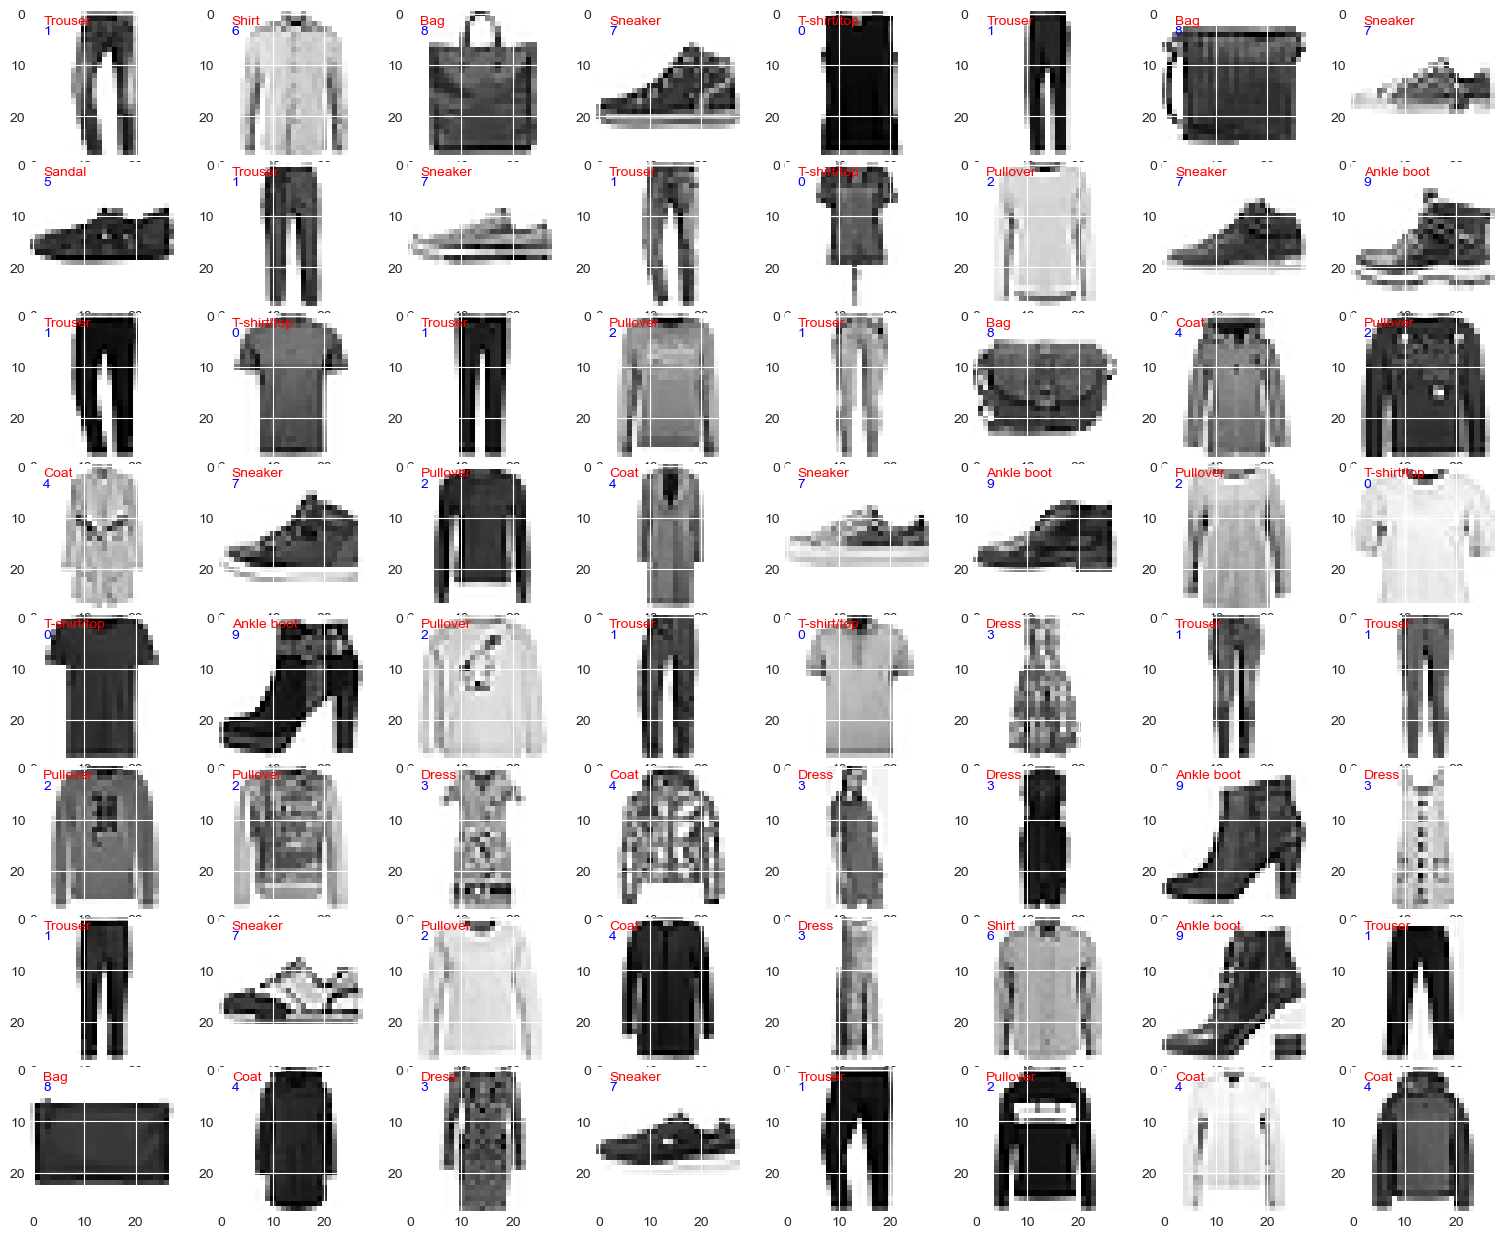

In [6]:
no_rows = 8
no_cols = 8

plot_df = train_df.sample(no_rows*no_cols)

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

for idx, row in plot_df.iterrows():
    i += 1
    image  = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(no_rows, no_cols, i)
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
    ax.text(2,4, str(row.values[0]),color='b', fontsize=10)
    ax.text(2,2, class_names[row.values[0]],color='r', fontsize=10)

plt.show()  


$$\text{
    Train Test Split
}
$$

In [7]:
X_data = train_df.drop(columns=['label'], axis=1).to_numpy()
y_data = train_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid = valid_df.drop(columns=['label'], axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((48000, 784), (12000, 784), (48000,), (12000,))

$$\text{
    Scaling the Dataset
}
$$

In [8]:
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

$$
\text{
Converting to dataset for batch processing instead of all data training at once
}
$$

In [9]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))

type(train_ds), type(test_ds), type(valid_ds)

(tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset)

In [10]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

in_len = train_shape[1]
out_len = len(np.unique(y_train))

In [11]:
import gc

# del train_df, valid_df, X_train, y_train, X_test, y_test, X_valid, y_valid
gc.collect()
gc.collect()

0

$$
\text{
    Converting the data to a tensor dataset using Preprocessing and Batching
}
$$

In [12]:
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [13]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# ONly for testing
next(iter(train_ds))

(<tf.Tensor: shape=(32, 784), dtype=float64, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([3, 3, 0, 7, 8, 4, 6, 0, 3, 5, 0, 3, 9, 8, 3, 8, 6, 8, 3, 1, 2, 3,
        8, 9, 1, 3, 8, 4, 0, 5, 7, 5], dtype=int64)>)

$$\text{
    Creating the model
}
$$

**Sequential API**

```python
model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_len,), name = 'input'), 
    tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1'),
    tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2'),
    tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3'),
    tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4'),
    tf.keras.layers.Dense(out_len, name = 'output')
])
````

**Functional API**

In [17]:
# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1')(inputs)
x = tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2')(x)
x = tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3')(x)
x = tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4')(x)

# Output 
outputs = tf.keras.layers.Dense(out_len, name='output')(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [ ]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [21]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)


# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [22]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7607 - loss: 0.6691 - val_accuracy: 0.8591 - val_loss: 0.3935
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8540 - loss: 0.4019 - val_accuracy: 0.8663 - val_loss: 0.3687
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8717 - loss: 0.3528 - val_accuracy: 0.8706 - val_loss: 0.3582
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8816 - loss: 0.3241 - val_accuracy: 0.8731 - val_loss: 0.3482
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8882 - loss: 0.3027 - val_accuracy: 0.8826 - val_loss: 0.3207
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8954 - loss: 0.2819 - val_accuracy: 0.8738 - val_loss: 0.3472
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9002 - loss: 0.2677 - val_accuracy: 0.8797 - val_loss: 0.3370
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9029 - loss: 0

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.812187,0.520366,0.859083,0.393512
1,0.858208,0.389114,0.866333,0.368683
2,0.873500,0.348000,0.870583,0.358192


,accuracy,loss,val_accuracy,val_loss
97,0.981687,0.053662,0.885000,0.869096
98,0.979500,0.057478,0.886500,0.809414
99,0.981812,0.053924,0.883333,0.862602


<Axes: >

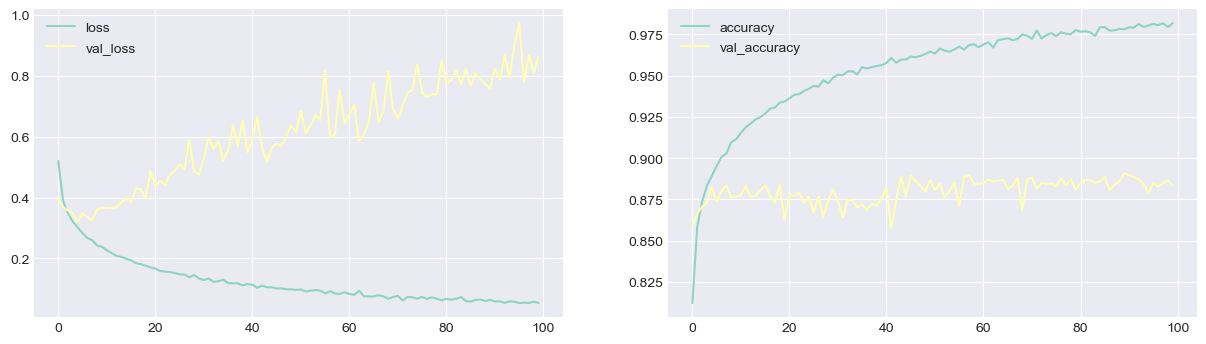

In [33]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fig, axes = plt.subplots(1,2)
hist_df.plot(y=['loss', 'val_loss'], ax= axes[0])
hist_df.plot(y=['accuracy', 'val_accuracy'], ax = axes[1])

In [34]:
pd.DataFrame(history.history)

,accuracy,loss,val_accuracy,val_loss
0,0.812187,0.520366,0.859083,0.393512
1,0.858208,0.389114,0.866333,0.368683
2,0.873500,0.348000,0.870583,0.358192
3,0.883333,0.321026,0.873083,0.348173
4,0.889229,0.302161,0.882583,0.320660
...,...,...,...,...
95,0.981271,0.053071,0.885250,0.973394
96,0.980646,0.054694,0.882750,0.779546
97,0.981687,0.053662,0.885000,0.869096
98,0.979500,0.057478,0.886500,0.809414


$$\text{
Creating the Prediction Model
}
$$

In [35]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)


$$
\text{
    If train dataframe is avaliable the only perform following steps 
}
$$

In [36]:
y_pred = model.predict(X_train)
accuracy_score(y_true= y_train, y_pred = y_pred.argmax(axis=1))

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


0.9614583333333333

$$
\text{
Train Data Accuracy and Confusion Matrix
}
$$

In [47]:
y_true, y_pred = [], []
for count, data in enumerate(train_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(48000, 48000)

In [48]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.9614583333333333

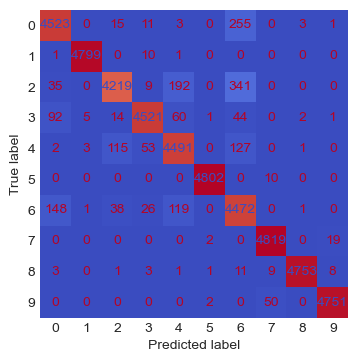

In [39]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)

$$
\text{
Test Data Accuracy and Confusion Matrix
}
$$

In [40]:
y_true, y_pred = [], []
for count, data in enumerate(test_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(12000, 12000)

In [41]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8833333333333333

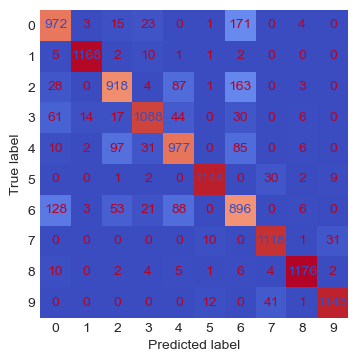

In [42]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)

$$
\text{
Validation Data Accuracy and Confusion Matrix
}
$$

In [43]:
y_true, y_pred = [], []
for count, data in enumerate(valid_ds):
    feat, label = data
    pred = prediction_model(feat).numpy().argmax(axis=1)
    y_true.extend(label)
    y_pred.extend(pred)
    
len(y_true), len(y_pred)

(10000, 10000)

In [44]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.8855

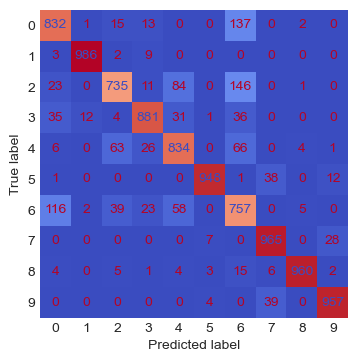

In [45]:
cm = confusion_matrix(y_true=y_true, y_pred= y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=sorted(np.unique(y_train)))
fig,ax = plt.subplots(figsize=(4,4))
disp.plot(ax=ax, cmap= CMAP, colorbar = False)
ax.grid(False)